## Training IBC extracted gasket with PNG images and black background

## Libraries

In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:

import matplotlib.pyplot as plt
from numpy import expand_dims
from PIL import Image
import numpy as np
import PIL
import cv2
import os
from random import sample

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json, model_from_yaml

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


In [3]:
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None))
print(tf.config.list_physical_devices('GPU'))

True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Function to save as pb 

In [4]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.

    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

## Testing Directories

In [5]:
# healthy_img_path = os.listdir("fotos/Healthy/p01/")[0]
# healthy_img=image.load_img("fotos/Healthy/p01/"+healthy_img_path)
# healthy_img.size
# plt.title("Healthy image")
# plt.imshow(healthy_img)

In [6]:
# ng_img_path = os.listdir("fotos/ng/")[0]
# ng_img=image.load_img("fotos/ng/"+ng_img_path)
# ng_img.size
# plt.title("NG image")
# plt.imshow(ng_img)

## Setting Directories

In [7]:
base_dir = "./output/"

train_dir = os.path.join(base_dir, "train")
train_good_dir = os.path.join(train_dir, "Healthy")
train_defect_dir = os.path.join(train_dir, "Sick")

# Test is used after training to test model
test_dir = os.path.join(base_dir, "test")
test_good_dir = os.path.join(test_dir, "Healthy")
test_defect_dir = os.path.join(test_dir, "Sick")

In [8]:
num_good_train = len(os.listdir(train_good_dir))
num_defect_train = len(os.listdir(train_defect_dir))

num_good_test = len(os.listdir(test_good_dir))
num_defect_test= len(os.listdir(test_defect_dir))

## Dataset Characteristics

In [9]:
print("Total Training Good Images",num_good_train)
print("Total Training Defect Images",num_defect_train)
print("--")
print("Total Test Good Images", num_good_test)
print("Total Test Defect Images",num_defect_test)

total_train = num_good_train+num_defect_train
total_test = num_good_test+num_defect_test

print("--")
print("Total Training Images",total_train)
print("Total Testing Images",total_test)

Total Training Good Images 3476
Total Training Defect Images 825
--
Total Test Good Images 969
Total Test Defect Images 224
--
Total Training Images 4301
Total Testing Images 1193


## Formatting Dataset

In [10]:
IMG_SHAPE  = (640, 480) # Size of images, assuming they are square.
num_channels = 1 # Color channels of images (3 for color and 1 for grayscale).
batch_size = 8 # Bigger batch size leads to a faster training, but can affect loss and accuracy metrics.

In [11]:
image_gen_train = ImageDataGenerator(rescale = 1./255, horizontal_flip=True, validation_split=0.15)
train_data_gen=image_gen_train.flow_from_directory(
    batch_size = batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=IMG_SHAPE,
    color_mode="grayscale",
    class_mode='binary',
    subset="training")

validation_data_gen=image_gen_train.flow_from_directory(
batch_size = batch_size,
directory=train_dir,
shuffle=True,
target_size=IMG_SHAPE,
color_mode="grayscale",
class_mode='binary',
subset="validation")

image_gen_test=ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_data_gen=image_gen_test.flow_from_directory(
    batch_size=batch_size,
    directory=test_dir,
    shuffle=False,
    target_size=IMG_SHAPE,
    color_mode="grayscale",
    class_mode='binary')

Found 4328 images belonging to 2 classes.
Found 763 images belonging to 2 classes.
Found 1401 images belonging to 2 classes.


In [12]:
train_data_gen.class_indices

{'Healthy': 0, 'Sick': 1}

## VGG16 Model 

In [13]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(640,480,1), 
                                                include_top=False, weights=None)

In [14]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [15]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.GaussianNoise(.1)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dense(2, activation='softmax')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [16]:
model = tf.keras.Model(pre_trained_model.input, x)

## Compiling model

In [17]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])

In [18]:
filepath = 'termografias.h5'

# Model Checkpoint callback save the best model, not last.
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Early Stopping callback will stop training if some monitor metric doesn't improve in n epochs (patience).
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

callbacks = [checkpoint]

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 640, 480, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 640, 480, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 640, 480, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 320, 240, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 320, 240, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 320, 240, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 160, 120, 128)     0     

## Training

In [20]:
import time

n_epochs = 10

start_time = time.time()

vgg_classifier = model.fit(train_data_gen,
    steps_per_epoch=(total_train//batch_size),
    validation_data=validation_data_gen,
    epochs = n_epochs,
    shuffle=True,
    batch_size = batch_size,
    verbose = 1,
    callbacks=callbacks)

total_time = time.time() - start_time

Epoch 1/10
537/537 [==============================] - ETA: 0s - loss: 0.6327 - acc: 0.6806
Epoch 1: val_loss improved from inf to 0.65409, saving model to termografias.h5
537/537 [==============================] - 53s 92ms/step - loss: 0.6327 - acc: 0.6806 - val_loss: 0.6541 - val_acc: 0.6828
Epoch 2/10
537/537 [==============================] - ETA: 0s - loss: 0.6320 - acc: 0.6832
Epoch 2: val_loss improved from 0.65409 to 0.64927, saving model to termografias.h5
537/537 [==============================] - 50s 93ms/step - loss: 0.6320 - acc: 0.6832 - val_loss: 0.6493 - val_acc: 0.6828
Epoch 3/10
537/537 [==============================] - ETA: 0s - loss: 0.6295 - acc: 0.6818
Epoch 3: val_loss improved from 0.64927 to 0.63314, saving model to termografias.h5
537/537 [==============================] - 50s 93ms/step - loss: 0.6295 - acc: 0.6818 - val_loss: 0.6331 - val_acc: 0.6828
Epoch 4/10
537/537 [==============================] - ETA: 0s - loss: 0.6311 - acc: 0.6827
Epoch 4: val_loss d

In [21]:
model.save("'termografias_last.h5")

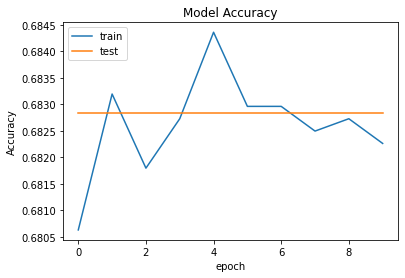

<Figure size 4320x1440 with 0 Axes>

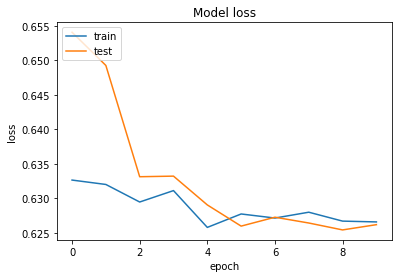

<Figure size 1440x720 with 0 Axes>

In [22]:
# plotting the training accuracy and loss
# Training and validation accuracy:
import matplotlib.pyplot as plt
plt.plot(vgg_classifier.history['acc'])
plt.plot(vgg_classifier.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.figure(figsize = (60,20))
plt.show()

# Summarize history for loss
plt.plot(vgg_classifier.history['loss'],)
plt.plot(vgg_classifier.history['val_loss'],)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.figure(figsize = (20,10))
plt.show()

## Testing 

In [23]:
from tensorflow import keras
print(os.getcwd())
model = keras.models.load_model('termografias.h5')

c:\Users\USER\Desktop\Proyectos\Guillermo


In [24]:
result = model.evaluate(test_data_gen,batch_size=batch_size)
print("test_loss, test accuracy", result)

176/176 [==============================] - 14s 80ms/step - loss: 0.6194 - acc: 0.6916
test_loss, test accuracy [0.619369626045227, 0.6916488409042358]


## Calculate threshold

In [25]:
Y_pred = model.predict(test_data_gen,total_test//batch_size)

In [26]:
## extracting NG and G pred, then order and then 
ng_items = len(test_data_gen.classes) - np.count_nonzero(test_data_gen.classes)
ng_ypred = np.copy(Y_pred[0:ng_items])
g_items = np.count_nonzero(test_data_gen.classes)
g_ypred = np.copy(Y_pred[ng_items:])

In [27]:
import pandas as pd
ng_analysis = [0,0,0,0,0,0,0,0,0,0]
for i in range(ng_items):
    if ng_ypred[i] <= .1:
        ng_analysis[0] += 1
    elif .1 < ng_ypred[i] <= .2:
        ng_analysis[1] += 1
    elif .2 < ng_ypred[i] <= .3:
        ng_analysis[2] += 1
    elif .3 < ng_ypred[i] <= .4:
        ng_analysis[3] += 1
    elif .4 < ng_ypred[i] <= .5:
        ng_analysis[4] += 1
    elif .5 < ng_ypred[i] <= .6:
        ng_analysis[5] += 1
    elif .6 < ng_ypred[i] <= .7:
        ng_analysis[6] += 1
    elif .7 < ng_ypred[i] <= .8:
        ng_analysis[7] += 1
    elif .8 < ng_ypred[i] <= .9:
        ng_analysis[8] += 1
    elif .9 < ng_ypred[i] <= 1:
        ng_analysis[9] += 1
    else: 
        0
g_analysis = [0,0,0,0,0,0,0,0,0,0]
for i in range(g_items):
    if g_ypred[i] <= .1:
        g_analysis[0] += 1
    elif .1 < g_ypred[i] <= .2:
        g_analysis[1] += 1
    elif .2 < g_ypred[i] <= .3:
        g_analysis[2] += 1
    elif .3 < g_ypred[i] <= .4:
        g_analysis[3] += 1
    elif .4 < g_ypred[i] <= .5:
        g_analysis[4] += 1
    elif .5 < g_ypred[i] <= .6:
        g_analysis[5] += 1
    elif .6 < g_ypred[i] <= .7:
        g_analysis[6] += 1
    elif .7 < g_ypred[i] <= .8:
        g_analysis[7] += 1
    elif .8 < g_ypred[i] <= .9:
        g_analysis[8] += 1
    elif .9 < g_ypred[i] <= 1:
        g_analysis[9] += 1
    else: 
        0 
        
ng = pd.DataFrame(ng_analysis, columns = [''])
ng = ng.set_index([pd.Index(['0-.1','.1-.2','.2-.3','.3-.4','.4-.5','.5-.6','.6-.7','.7-.8','.8-.9','.9-1'])])
ng = ng.transpose()
print('Prediction values distribution of Defected Parts')
print(ng)

g = pd.DataFrame(g_analysis, columns = [''])
g = g.set_index([pd.Index(['0-.1','.1-.2','.2-.3','.3-.4','.4-.5','.5-.6','.6-.7','.7-.8','.8-.9','.9-1'])])
g = g.transpose()
print('Prediction values distribution of Good Parts')
print(g)

Prediction values distribution of Defected Parts
  0-.1  .1-.2  .2-.3  .3-.4  .4-.5  .5-.6  .6-.7  .7-.8  .8-.9  .9-1
     0      0      0    969      0      0      0      0      0     0
Prediction values distribution of Good Parts
  0-.1  .1-.2  .2-.3  .3-.4  .4-.5  .5-.6  .6-.7  .7-.8  .8-.9  .9-1
     0      0      0    432      0      0      0      0      0     0


In [28]:
import statistics
median_ng = statistics.median(ng_ypred)
mean_ng = np.sum(ng_ypred)/len(ng_ypred)
min_ng = np.max(ng_ypred)

mean_g = np.sum(g_ypred)/len(g_ypred)
median_g = statistics.median(g_ypred)
min_g = np.min(g_ypred)

print("Defected Images Median:", median_ng)
print("Defected Images Mean:", mean_ng)
print("Defected Images Maximum value:", min_ng)

print("Good Images Median:",median_g)
print("Good Images Mean:",mean_g)
print("Good Images Minimum value:", min_g)

Defected Images Median: [0.33483648]
Defected Images Mean: 0.3348363476764061
Defected Images Maximum value: 0.3348511
Good Images Median: [0.33483788]
Good Images Mean: 0.3348385846173322
Good Images Minimum value: 0.3348299


## Confusion Matrix

In [29]:
threshold = .50

In [30]:
confussion_preds = np.copy(Y_pred)

In [31]:
for i in range(len(test_data_gen.classes)):
    if i < np.count_nonzero(test_data_gen.classes) : # iterate through pred of NG
        if confussion_preds[i] <= threshold :
            confussion_preds[i] = 0
        else:
            confussion_preds[i] = 1    
    else:
        if confussion_preds[i] >= threshold :
            confussion_preds[i] = 1
        else:
            confussion_preds[i] = 0

In [32]:
import seaborn as sns

cf_matrix = confusion_matrix(test_data_gen.classes, confussion_preds)

print('Confusion Matrix')
print(cf_matrix)
print('Classification Report')
target_names = ['Bad','Good']
print(classification_report(test_data_gen.classes, confussion_preds, target_names=target_names))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['NG','OK'])
ax.yaxis.set_ticklabels(['NG','OK'])

## Display the visualization of the Confusion Matrix.
plt.show()

plot = ax.get_figure()
plot.savefig("confussion_matrix.jpg")

ModuleNotFoundError: No module named 'seaborn'

## NG IMAGES

In [ ]:
images = []
folder_path = test_defect_dir
images_list = os.listdir(folder_path)
for img in images_list:
    img_path = os.path.join(folder_path, img)
    img = plt.imread(img_path)
    images.append(img)

In [ ]:
from matplotlib.patches import Rectangle
color = 'none'
true_negative = 0
false_negative = 0

to_show = 10
nrows = 5
ncols = 5

i = 0
for row in range(nrows):
    row += 1
    plt.figure(figsize=(20,10))
    for col in range(ncols):
        col += 1
        # print(ng_ypred[i])
        pred = f"{ng_ypred[i, 0]:.4f}"
        
        plt.subplot(1, ncols, col)
        plt.text(IMG_SHAPE/2, IMG_SHAPE-5,"Pred =" + pred, color="orange", fontdict={"fontsize":13,"fontweight":'bold',"ha":"center", "va":"baseline"})
        
        if ng_ypred[i] < threshold:
            color = 'g'
            true_negative = true_negative +1
        else:
            color = 'r'
            false_negative = false_negative +1
        plt.gca().add_patch(Rectangle((0,0),IMG_SHAPE,IMG_SHAPE,linewidth=5,edgecolor=color,facecolor='none'))

        plt.imshow(images[i])
        i += 1

    plt.show()

print('True negative =' +' '+ str(true_negative))
print('False negative =' + ' '+ str(false_negative))
print ('Total evaluated parts =' + ' ' + str(true_negative+false_negative))

## OK IMAGES

In [ ]:
images = []
folder_path = test_good_dir
images_list = os.listdir(folder_path)
for img in images_list:
    img_path = os.path.join(folder_path, img)
    img = plt.imread(img_path)
    images.append(img)

In [ ]:
color = 'none'
true_positive = 0
false_positive = 0

print ('Evaluation on Good Parts')

i = 0
for row in range(nrows):
    row += 1
    plt.figure(figsize=(20,10))
    for col in range(ncols):
        col += 1
        pred = f"{g_ypred[i, 0]:.4f}"
        
        plt.subplot(1, ncols, col)
        plt.text(IMG_SHAPE/2, IMG_SHAPE-5,"Pred =" + pred, color="orange", fontdict={"fontsize":13,"fontweight":'bold',"ha":"center", "va":"baseline"})
        
        if ng_ypred[i] < threshold:
            color = 'g'
            true_negative = true_negative +1
        else:
            color = 'r'
            false_negative = false_negative +1
        plt.gca().add_patch(Rectangle((0,0),IMG_SHAPE,IMG_SHAPE,linewidth=5,edgecolor=color,facecolor='none'))

        plt.imshow(images[i])
        i += 1

    plt.show()
    
print('True positive =' +' '+ str(true_positive))
print('False positive =' + ' '+ str(false_positive))
print ('Total evaluated parts =' + ' ' + str(true_positive+false_positive))

## If saving last epoch in .pb from graph

In [ ]:
input_node_names = [node.op.name for node in model.inputs]
print('Input nodes names are:', str(input_node_names))

In [ ]:
outputs_node_names=[node.op.name for node in model.outputs]
print('Output nodes names are:', str(outputs_node_names))

In [ ]:
frozen_graph = freeze_session(K.get_session(),output_names=[out.op.name for out in model.outputs])
# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, "./", "ibc_gasket_training4.pb", as_text=False)

### Brief training report (.txt)

In [ ]:
with open("training_report_fakra1011.txt", "w") as f:
    f.write(f"Total number of epochs: {n_epochs} \n")
    f.write(f"Total time taken: {total_time/60} minutes \n")
    f.write("\nModel architecture: \n")
    model.summary(print_fn=lambda x: f.write(x + "\n"))
    f.write(f"\nInput node name: {input_node_names[0]}")
    f.write(f"\nInput node name: {outputs_node_names[0]}")